# Using whisper to transcribe audio

In [1]:
!pip install git+https://github.com/openai/whisper.git
# !sudo apt update && sudo apt install ffmpeg   #run in terminal

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-1h3vy_mf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-1h3vy_mf
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 6.8 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=810e91940ad245b9923eb288b2b0ed0879c6454e26337eca6310e83fee9d24bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-kn8e8qe3/wheels/c3/03/25/5e0ba78bc27a3a089f137c9f1d92fdfce16d06996c071a016c
Successfully built openai-whisper


In [ ]:
!whisper -h

usage: whisper [-h] [--model MODEL] [--model_dir MODEL_DIR] [--device DEVICE]
               [--output_dir OUTPUT_DIR]
               [--output_format {txt,vtt,srt,tsv,json,all}]
               [--verbose VERBOSE] [--task {transcribe,translate}]
               [--language {af,am,ar,as,az,ba,be,bg,bn,bo,br,bs,ca,cs,cy,da,de,el,en,es,et,eu,fa,fi,fo,fr,gl,gu,ha,haw,he,hi,hr,ht,hu,hy,id,is,it,ja,jw,ka,kk,km,kn,ko,la,lb,ln,lo,lt,lv,mg,mi,mk,ml,mn,mr,ms,mt,my,ne,nl,nn,no,oc,pa,pl,ps,pt,ro,ru,sa,sd,si,sk,sl,sn,so,sq,sr,su,sv,sw,ta,te,tg,th,tk,tl,tr,tt,uk,ur,uz,vi,yi,yo,yue,zh,Afrikaans,Albanian,Amharic,Arabic,Armenian,Assamese,Azerbaijani,Bashkir,Basque,Belarusian,Bengali,Bosnian,Breton,Bulgarian,Burmese,Cantonese,Castilian,Catalan,Chinese,Croatian,Czech,Danish,Dutch,English,Estonian,Faroese,Finnish,Flemish,French,Galician,Georgian,German,Greek,Gujarati,Haitian,Haitian Creole,Hausa,Hawaiian,Hebrew,Hindi,Hungarian,Icelandic,Indonesian,Italian,Japanese,Javanese,Kannada,Kazakh,Khmer,Korean,Lao,L

In [ ]:
!whisper "/content/testaudio1.wav" --model medium.en

100%|█████████████████████████████████████| 1.42G/1.42G [00:42<00:00, 35.7MiB/s]
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
[00:00.000 --> 00:05.560]  Hello, this is a test, I want to see if this works.


#Test recording audio


In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
!pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display, Audio
from google.colab import output
import numpy as np
import io
import base64

# Create start and stop buttons
start_button = widgets.Button(description="Start Recording")
stop_button = widgets.Button(description="Stop Recording")

recording = False

# Function to start recording
def start_recording(b):
    global recording
    recording = True
    output.eval_js('startRecording()')
    print("Recording started...")

# Function to stop recording and save the file
def stop_recording(b):
    global recording
    if not recording:
        print("No recording in progress.")
        return

    recording = False
    audio_data = output.eval_js('stopRecording()')

    if audio_data is None:
        print("No audio data recorded.")
        return

    # Decode base64 data
    audio_bytes = base64.b64decode(audio_data['audio'])

    # Create and display Audio widget
    audio_obj = Audio(data=audio_bytes, rate=audio_data['sampleRate'])
    display(audio_obj)

    # Save as WAV file
    with open("recorded_audio.wav", "wb") as f:
        f.write(audio_bytes)

    print("Audio saved as 'recorded_audio.wav'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.3 MB/s eta 0:00:00


In [5]:
#record invoice
# Connect buttons to functions
start_button.on_click(start_recording)
stop_button.on_click(stop_recording)

# Display buttons
display(start_button, stop_button)

# JavaScript to handle audio recording
output.eval_js('''
    let recorder, stream;

    async function startRecording() {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true });
        recorder = new MediaRecorder(stream);
        chunks = [];
        recorder.ondataavailable = e => chunks.push(e.data);
        recorder.start();
    }

    function stopRecording() {
        return new Promise(resolve => {
            recorder.onstop = () => {
                const blob = new Blob(chunks, { type: 'audio/wav' });
                chunks = [];
                stream.getTracks().forEach(track => track.stop());
                const reader = new FileReader();
                reader.onload = () => {
                    const base64data = reader.result.split(',')[1];
                    resolve({audio: base64data, sampleRate: 44100});
                };
                reader.readAsDataURL(blob);
            };
            recorder.stop();
        });
    }
''')

Button(description='Start Recording', style=ButtonStyle())

Button(description='Stop Recording', style=ButtonStyle())

Recording started...


Audio saved as 'recorded_audio.wav'
Recording started...


Audio saved as 'recorded_audio.wav'


#Test first agent router

In [8]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [9]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


Here, we'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

We'll log to a project, `langchain-academy`.

In [10]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Dreamjournal-Agent"

LANGSMITH_API_KEY: ··········


In [11]:
from langchain_openai import ChatOpenAI
import whisper
import time
from IPython.display import display


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


def transcribe(audio_path: str) -> str:
    """Transcribe an audio file using Whisper Python API.

    Args:
        audio_path: Path to the audio file.

    Returns:
        The transcription as a string.
    """
    # Load the model
    model = whisper.load_model("medium.en")

    # Transcribe the audio
    result = model.transcribe(audio_path)

    # Return the text only
    return result["text"]


def record_audio() -> str:
    """
    Displays the audio recording UI for the user.
    The user must record audio manually.
    """

    #record invoice
    # Connect buttons to functions
    start_button.on_click(start_recording)
    stop_button.on_click(stop_recording)

    # Display buttons
    display(start_button, stop_button)

    # JavaScript to handle audio recording
    output.eval_js('''
        let recorder, stream;

        async function startRecording() {
            stream = await navigator.mediaDevices.getUserMedia({ audio: true });
            recorder = new MediaRecorder(stream);
            chunks = [];
            recorder.ondataavailable = e => chunks.push(e.data);
            recorder.start();
        }

        function stopRecording() {
            return new Promise(resolve => {
                recorder.onstop = () => {
                    const blob = new Blob(chunks, { type: 'audio/wav' });
                    chunks = [];
                    stream.getTracks().forEach(track => track.stop());
                    const reader = new FileReader();
                    reader.onload = () => {
                        const base64data = reader.result.split(',')[1];
                        resolve({audio: base64data, sampleRate: 44100});
                    };
                    reader.readAsDataURL(blob);
                };
                recorder.stop();
            });
        }
    ''')

    return (
        "Audio recording UI displayed. "
        "Please click Start Recording, then Stop Recording. "
        "The file will be saved as recorded_audio.wav."
    )

tools = [add, multiply, divide,transcribe, record_audio]
llm = ChatOpenAI(model="gpt-4o")


llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [12]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with making calculations or using a tool to transcribe audio or use a tool that the user can use to record audio, when the user uses record audio you can finish the session")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

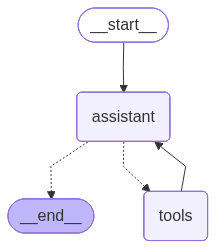

In [13]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Add 3 and 8. Multiply the output by 10. Divide the output by 2")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 8. Multiply the output by 10. Divide the output by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_WoQdU9CRyu5oNnQ9OMBYfsxZ)
 Call ID: call_WoQdU9CRyu5oNnQ9OMBYfsxZ
  Args:
    a: 3
    b: 8
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================
Tool Calls:
  multiply (call_qEpOxcwzNLqGPnDS11tWrmvK)
 Call ID: call_qEpOxcwzNLqGPnDS11tWrmvK
  Args:
    a: 11
    b: 10
================================= Tool Message =================================
Name: multiply

110
================================== Ai Message ==================================
Tool Calls:
  divide (call_AzSY5u5xouT1CCru9TEAjqKB)
 Call ID: call_AzSY5u5xouT1CCru9TEAjqKB
  Args:
    a: 110
    b: 2
================================= Tool Message =========

In [ ]:
messages = [HumanMessage(content="transcribe this audio file /content/recorded_audio.wav and return the text ")]
messages = react_graph.invoke({"messages": messages})

100%|█████████████████████████████████████| 1.42G/1.42G [00:18<00:00, 80.4MiB/s]
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

transcribe this audio file /content/recorded_audio.wav and return the text 
================================== Ai Message ==================================
Tool Calls:
  transcribe (call_xLbL72bleBZHgTEZDtEVSV78)
 Call ID: call_xLbL72bleBZHgTEZDtEVSV78
  Args:
    audio_path: /content/recorded_audio.wav
================================= Tool Message =================================
Name: transcribe

 Hello, this is a test, I want to see if this works.
================================== Ai Message ==================================

The transcription of the audio file is: "Hello, this is a test, I want to see if this works."


In [14]:
messages = [HumanMessage(content="I want to use the record audio function ")]
messages = react_graph.invoke({"messages": messages})

Button(description='Start Recording', style=ButtonStyle())

Button(description='Stop Recording', style=ButtonStyle())

Recording started...


Audio saved as 'recorded_audio.wav'


In [15]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to use the record audio function 
================================== Ai Message ==================================
Tool Calls:
  record_audio (call_hEGOar8wtv7diKpIf7Zkyed2)
 Call ID: call_hEGOar8wtv7diKpIf7Zkyed2
  Args:
================================= Tool Message =================================
Name: record_audio

Audio recording UI displayed. Please click Start Recording, then Stop Recording. The file will be saved as recorded_audio.wav.
================================== Ai Message ==================================

I have provided the audio recording interface. Please go ahead and record your audio, then let me know once you have completed the recording.


# test transcribe function

In [ ]:
import subprocess
import os

def transcribe(audio_path: str) -> str:
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")

    # Run whisper
    cmd = f'whisper "{audio_path}" --model medium.en --output_format txt'
    subprocess.run(cmd, shell=True, check=True)

    txt_file = os.path.splitext(audio_path)[0] + ".txt"
    if not os.path.exists(txt_file):
        raise FileNotFoundError(f"Transcription file not found: {txt_file}")

    with open(txt_file, "r", encoding="utf-8") as f:
        transcription = f.read()

    return transcription


In [ ]:
transcribe("/content/recorded_audio.wav")

"I'm trying to talk English with you because I feel that I need to talk.\n"

In [ ]:
import whisper

def transcribe(audio_path: str) -> str:
    """Transcribe an audio file using Whisper Python API.

    Args:
        audio_path: Path to the audio file.

    Returns:
        The transcription as a string.
    """
    # Load the model
    model = whisper.load_model("medium.en")

    # Transcribe the audio
    result = model.transcribe(audio_path)

    # Return the text only
    return result["text"]


In [ ]:
transcribe("/content/recorded_audio.wav")

/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


" Hello, hello, hello, here is Zemedan. I'm trying to talk English with you because I feel that I need to talk."

In [ ]:

def record_audio() -> str:
    """
    Displays the audio recording UI and waits for the user
    to finish recording. Returns the path to the WAV file.
    """

    audio_path = "recorded_audio.wav"

    # Show the already-created widgets
    display(start_button, stop_button)

    print("🎤 Please record audio using the buttons above.")
    print("⏳ Waiting for recording to finish...")

    # Wait until the file exists
    while True:
        try:
            with open(audio_path, "rb"):
                break
        except FileNotFoundError:
            time.sleep(1)

    print("✅ Recording detected.")
    return audio_path

In [ ]:
test = record_audio()

Button(description='Start Recording', style=ButtonStyle())

Button(description='Stop Recording', style=ButtonStyle())

🎤 Please record audio using the buttons above.
⏳ Waiting for recording to finish...


KeyboardInterrupt: 

MessageError: ReferenceError: startRecording is not defined

In [6]:
from IPython.display import display

def record_audio() -> str:
    """
    Displays the audio recording UI for the user.
    The user must record audio manually.
    """

    #record invoice
    # Connect buttons to functions
    start_button.on_click(start_recording)
    stop_button.on_click(stop_recording)

    # Display buttons
    display(start_button, stop_button)

    # JavaScript to handle audio recording
    output.eval_js('''
        let recorder, stream;

        async function startRecording() {
            stream = await navigator.mediaDevices.getUserMedia({ audio: true });
            recorder = new MediaRecorder(stream);
            chunks = [];
            recorder.ondataavailable = e => chunks.push(e.data);
            recorder.start();
        }

        function stopRecording() {
            return new Promise(resolve => {
                recorder.onstop = () => {
                    const blob = new Blob(chunks, { type: 'audio/wav' });
                    chunks = [];
                    stream.getTracks().forEach(track => track.stop());
                    const reader = new FileReader();
                    reader.onload = () => {
                        const base64data = reader.result.split(',')[1];
                        resolve({audio: base64data, sampleRate: 44100});
                    };
                    reader.readAsDataURL(blob);
                };
                recorder.stop();
            });
        }
    ''')

    return (
        "Audio recording UI displayed. "
        "Please click Start Recording, then Stop Recording. "
        "The file will be saved as recorded_audio.wav."
    )


In [7]:
record_audio()

Button(description='Start Recording', style=ButtonStyle())

Button(description='Stop Recording', style=ButtonStyle())

'Audio recording UI displayed. Please click Start Recording, then Stop Recording. The file will be saved as recorded_audio.wav.'

Recording started...


Audio saved as 'recorded_audio.wav'


#adding memory

In [16]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [ ]:
#example

In [17]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_U8rG8KjKZtxJq6lCZ75sty51)
 Call ID: call_U8rG8KjKZtxJq6lCZ75sty51
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [18]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_U8rG8KjKZtxJq6lCZ75sty51)
 Call ID: call_U8rG8KjKZtxJq6lCZ75sty51
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_K1hHmL1RoMYLDTE0Is0k9TLg)
 Call ID: call_K1hHmL1RoMYLDTE0Is0k9TLg
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Multiplying 7 by 2 gi

In [ ]:
#our

In [19]:
# Specify a thread
config = {"configurable": {"thread_id": "7"}}

# Specify an input
messages = [HumanMessage(content="can I record some audio?")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

Button(description='Start Recording', style=ButtonStyle())

Button(description='Stop Recording', style=ButtonStyle())

================================ Human Message =================================

can I record some audio?
================================== Ai Message ==================================
Tool Calls:
  record_audio (call_rykqOGDaojnlmqCuKWptXkQQ)
 Call ID: call_rykqOGDaojnlmqCuKWptXkQQ
  Args:
================================= Tool Message =================================
Name: record_audio

Audio recording UI displayed. Please click Start Recording, then Stop Recording. The file will be saved as recorded_audio.wav.
================================== Ai Message ==================================

Please record your audio by clicking 'Start Recording', and once you are done, click 'Stop Recording'. The audio will be saved as 'recorded_audio.wav'. Let me know when you are finished!
Recording started...


Audio saved as 'recorded_audio.wav'


In [20]:
messages = [HumanMessage(content="can you now transcribe the audio file /content/recorded_audio.wav ")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

100%|█████████████████████████████████████| 1.42G/1.42G [00:28<00:00, 53.1MiB/s]
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


================================ Human Message =================================

can I record some audio?
================================== Ai Message ==================================
Tool Calls:
  record_audio (call_rykqOGDaojnlmqCuKWptXkQQ)
 Call ID: call_rykqOGDaojnlmqCuKWptXkQQ
  Args:
================================= Tool Message =================================
Name: record_audio

Audio recording UI displayed. Please click Start Recording, then Stop Recording. The file will be saved as recorded_audio.wav.
================================== Ai Message ==================================

Please record your audio by clicking 'Start Recording', and once you are done, click 'Stop Recording'. The audio will be saved as 'recorded_audio.wav'. Let me know when you are finished!
================================ Human Message =================================

can you now transcribe the audio file /content/recorded_audio.wav 
================================== Ai Message =============